In [29]:
"""
=============================================================================
UYGULAMA 01 — Veri Ön İşleme Temelleri
=============================================================================
Kapsam:
  - Veri yükleme ve keşifsel analiz (EDA)
  - Eksik değer tespiti ve SimpleImputer ile doldurma
  - StandardScaler ile ölçekleme
  - OneHotEncoder ve OrdinalEncoder ile kategorik dönüşüm
  - fit() ve transform() arasındaki kritik fark (Data Leakage)
  - Preprocessing öncesi ve sonrası görselleştirme

Veri seti: UCI Bank Marketing (ya da yerleşik örnek veri)
Kurulum:   pip install scikit-learn pandas numpy matplotlib seaborn
=============================================================================
"""

'\n=============================================================================\nUYGULAMA 01 — Veri Ön İşleme Temelleri\n=============================================================================\nKapsam:\n  - Veri yükleme ve keşifsel analiz (EDA)\n  - Eksik değer tespiti ve SimpleImputer ile doldurma\n  - StandardScaler ile ölçekleme\n  - OneHotEncoder ve OrdinalEncoder ile kategorik dönüşüm\n  - fit() ve transform() arasındaki kritik fark (Data Leakage)\n  - Preprocessing öncesi ve sonrası görselleştirme\n\nVeri seti: UCI Bank Marketing (ya da yerleşik örnek veri)\nKurulum:   pip install scikit-learn pandas numpy matplotlib seaborn\n=============================================================================\n'

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#SimpleImputer → Eksik değerleri dolduran araç
#StandardScaler → Sayıları aynı ölçeğe getiren araç
#OneHotEncoder → Kategorik veriyi sayıya çeviren araç (job, marital gibi)
#OrdinalEncoder → Sıralı kategorileri sayıya çeviren araç (eğitim seviyesi gibi)
#LabelEncoder → Import edilmiş ama bu kodda kullanılmıyor
#train_test_split → Veriyi eğitim/test olarak ikiye bölen araç

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
plt.rcParams.update({"font.family": "sans-serif", "axes.spines.top": False,
                     "axes.spines.right": False})

In [7]:
# ═════════════════════════════════════════════════════════════
# 1. VERİ YÜKLEME
# ═════════════════════════════════════════════════════════════
url = ("https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional-full.csv")
try:
    df = pd.read_csv(url, sep=";")
    print(f"    ✅ UCI Bank Marketing: {df.shape[0]:,} satır, {df.shape[1]} sütun")
except Exception:
    print("    ⚠️  İnternet yok — örnek veri oluşturuluyor...")

    ⚠️  İnternet yok — örnek veri oluşturuluyor...


In [12]:
print("\n[1] Veri yükleniyor...")

url = ("https://archive.ics.uci.edu/ml/machine-learning-databases"
       "/00222/bank-additional-full.csv")
try:
    df = pd.read_csv(url, sep=";")
    print(f"    ✅ UCI Bank Marketing: {df.shape[0]:,} satır, {df.shape[1]} sütun")
except Exception:
    print("    ⚠️  İnternet yok — örnek veri oluşturuluyor...")
    np.random.seed(42) #"42" bir başlangıç noktası. Bu sayede kod her çalıştırıldığında aynı rastgele sayılar üretilir. Tekrar üretilebilirlik sağlar.
    n = 4000
    df = pd.DataFrame({
        #18 ile 75 arasında n adet rastgele tam sayı üretir.Tam sayıyı ondalıklıya çevirir. 
        #Neden? Sonradan NaN (eksik değer) ekleyeceğiz; Python'da tam sayı sütunlar NaN tutamaz.
        "age":       np.random.randint(18, 75, n).astype(float), 
        "job":       np.random.choice(
                         ["admin.", "blue-collar", "technician",
                          "services", "management", "retired"], n),
        "marital":   np.random.choice(["married", "single", "divorced"], n),
        "education": np.random.choice(
                         ["basic.4y", "high.school",
                          "university.degree", "professional.course"], n),
        "balance":   np.random.normal(1500, 3000, n),
        "duration":  np.abs(np.random.normal(260, 260, n)),
        "campaign":  np.random.randint(1, 10, n).astype(float),
        "pdays":     np.random.choice(
                         [999] + list(range(0, 30)), n,
                         p=[0.85] + [0.005] * 30).astype(float),
        "previous":  np.random.randint(0, 5, n).astype(float),
        "contact":   np.random.choice(["telephone", "cellular"], n),
        "poutcome":  np.random.choice(
                         ["failure", "success", "nonexistent"], n),
        "y":         np.random.choice(["yes", "no"], n, p=[0.12, 0.88]),
    })
    print(f"    ✅ Örnek veri oluşturuldu: {df.shape}")



[1] Veri yükleniyor...
    ⚠️  İnternet yok — örnek veri oluşturuluyor...
    ✅ Örnek veri oluşturuldu: (4000, 12)


In [13]:
# Target sütunu
df["target"] = (df["y"] == "yes").astype(int) #Her satır için True/False üretir.True→1, False→0 dönüşümü.

In [14]:
# ─── Yapay eksik değer ekle (gerçekçi senaryo) ───────────────
np.random.seed(0)
for col in ["age", "balance", "duration"]:
#0 ile 1 arasında rastgele sayılar üretir.
#< 0.05 → Bu sayıların %5'i 0.05'ten küçük olur → o satırları seçer.
#= np.nan → Seçilen satırlara "eksik değer" yazar. Neden yapıyoruz? Gerçek hayat verisini simüle etmek için. 
    df.loc[np.random.rand(len(df)) < 0.05, col] = np.nan   # %5 eksik
for col in ["job", "education"]:
    df.loc[np.random.rand(len(df)) < 0.07, col] = np.nan   # %7 eksik

print("\n    Eksik değer sayıları:")
miss = df.isnull().sum()
print(miss[miss > 0].to_string())


    Eksik değer sayıları:
age          203
job          302
education    323
balance      222
duration     206


In [15]:
# ═════════════════════════════════════════════════════════════
# 2. EĞİTİM / TEST AYIRIMI
# ═════════════════════════════════════════════════════════════
print("\n[2] Eğitim/Test bölmesi yapılıyor...")

num_cols = ["age", "balance", "duration", "campaign", "pdays", "previous"]
cat_ohe  = ["job", "marital", "contact", "poutcome"]
cat_ord  = ["education"]

# Sadece mevcut sütunları al
num_cols = [c for c in num_cols if c in df.columns]
cat_ohe  = [c for c in cat_ohe  if c in df.columns]
cat_ord  = [c for c in cat_ord  if c in df.columns]
all_cols = num_cols + cat_ohe + cat_ord

X = df[all_cols].copy()
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
#stratify=y → Her iki kümede de hedef sınıf oranları korunur. Mesela veri %12 "yes" içeriyorsa, hem train hem test %12 "yes" içerir. Bu olmadan dengesiz dağılım oluşabilir.
)
print(f"    Eğitim: {X_train.shape[0]:,}  |  Test: {X_test.shape[0]:,}")


[2] Eğitim/Test bölmesi yapılıyor...
    Eğitim: 3,200  |  Test: 800


In [16]:
# ═════════════════════════════════════════════════════════════
# 3. SimpleImputer — Eksik Değer Doldurma
# ═════════════════════════════════════════════════════════════
print("\n[3] SimpleImputer ile eksik değer doldurma...")

# Sayısal: medyan stratejisi
#strategy="median" → Eksik değerleri o sütunun medyanı ile doldur. Ortalama yerine medyan tercih edilir çünkü aykırı değerlerden etkilenmez. 
#Örneğin maaş verisinde bir milyarder varsa ortalamayı çok yukarı çeker, ama medyanı çok az etkiler.
num_imputer = SimpleImputer(strategy="median")
X_train_num_imp = num_imputer.fit_transform(X_train[num_cols])
X_test_num_imp  = num_imputer.transform(X_test[num_cols])   # ← fit() YOK!

print("    Sayısal imputer öğrenilen medyanlar:")
for col, stat in zip(num_cols, num_imputer.statistics_):
    print(f"      {col:<12}: {stat:.2f}")

# Kategorik: en sık değer stratejisi
#strategy="most_frequent" → Kategorik sütunlar için en mantıklı strateji. En sık geçen değeri (mod) kullanır. 
#Medyan veya ortalama metin verisinde çalışmaz.
cat_imputer = SimpleImputer(strategy="most_frequent")
X_train_cat_imp = cat_imputer.fit_transform(X_train[cat_ohe + cat_ord])
X_test_cat_imp  = cat_imputer.transform(X_test[cat_ohe + cat_ord])

print("\n    Kategorik imputer öğrenilen mod değerleri:")
for col, stat in zip(cat_ohe + cat_ord, cat_imputer.statistics_):
    print(f"      {col:<12}: {stat}")

print("\n    ⚠️  Data Leakage Neden Oluşur?")
print("        Yanlış: imputer.fit_transform(X_tüm) → sonra ikiye bol")
print("        Doğru:  önce bol, imputer.fit(X_train), transform(X_test)")



[3] SimpleImputer ile eksik değer doldurma...
    Sayısal imputer öğrenilen medyanlar:
      age         : 46.00
      balance     : 1420.14
      duration    : 268.28
      campaign    : 5.00
      pdays       : 999.00
      previous    : 2.00

    Kategorik imputer öğrenilen mod değerleri:
      job         : retired
      marital     : single
      contact     : cellular
      poutcome    : success
      education   : professional.course

    ⚠️  Data Leakage Neden Oluşur?
        Yanlış: imputer.fit_transform(X_tüm) → sonra ikiye bol
        Doğru:  önce bol, imputer.fit(X_train), transform(X_test)


In [17]:
# ═════════════════════════════════════════════════════════════
# 4. StandardScaler — Ölçekleme
# ═════════════════════════════════════════════════════════════
print("\n[4] StandardScaler ile ölçekleme...")
#Neden ölçekleme gerekir?
#age sütunu: 18–75 arasında değerler
#balance sütunu: -10.000 ile 100.000 arasında değerler
#Mesafe bazlı algoritmalar (KNN, SVM, Lojistik Regresyon) büyük sayıları daha önemli sanır. Ölçekleme bu dengesizliği giderir.
#StandardScaler ne yapar?
#Her değer için: z = (değer − ortalama) / standart_sapma
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num_imp)
X_test_scaled  = scaler.transform(X_test_num_imp)

print("    Öğrenilen istatistikler (ilk 3 özellik):")
for i, col in enumerate(num_cols[:3]):
    print(f"      {col:<12}: ortalama={scaler.mean_[i]:.2f}, std={scaler.scale_[i]:.2f}")

# Ölçekleme sonrası kontrol
df_scaled = pd.DataFrame(X_train_scaled, columns=num_cols)
print(f"\n    Ölçekleme sonrası 'age' özeti:")
print(f"      ortalama ≈ {df_scaled['age'].mean():.4f}  (beklenen: ~0)")
print(f"      std      ≈ {df_scaled['age'].std():.4f}  (beklenen: ~1)")


[4] StandardScaler ile ölçekleme...
    Öğrenilen istatistikler (ilk 3 özellik):
      age         : ortalama=45.89, std=15.88
      balance     : ortalama=1435.28, std=2912.92
      duration    : ortalama=298.85, std=204.33

    Ölçekleme sonrası 'age' özeti:
      ortalama ≈ 0.0000  (beklenen: ~0)
      std      ≈ 1.0002  (beklenen: ~1)


In [18]:
# ═════════════════════════════════════════════════════════════
# 5. OneHotEncoder
# ═════════════════════════════════════════════════════════════
print("\n[5] OneHotEncoder ile kategorik dönüşüm...")
#OneHotEncoder neden gerekli?
#job sütunu: "admin.", "blue-collar", "technician" gibi değerler içeriyor.
#Model bu kelimeleri anlayamaz. OHE her kategori için ayrı bir sütun oluşturur
#handle_unknown="ignore" → Test setinde eğitimde görülmemiş bir kategori çıkarsa hata vermek yerine o satır için tüm sütunlara 0 yazar.
#sparse_output=False → Normalde hafıza tasarrufu için seyrek matris döner. False dersek normal numpy dizisi olarak döner — işlemesi daha kolay.
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_train_cat_df = pd.DataFrame(X_train_cat_imp, columns=cat_ohe + cat_ord)
X_test_cat_df  = pd.DataFrame(X_test_cat_imp,  columns=cat_ohe + cat_ord)

X_train_ohe = ohe.fit_transform(X_train_cat_df[cat_ohe])
X_test_ohe  = ohe.transform(X_test_cat_df[cat_ohe])

ohe_names = ohe.get_feature_names_out(cat_ohe)
print(f"    {len(cat_ohe)} kategorik sütun → {len(ohe_names)} binary sütun")
print(f"    Örnekler: {list(ohe_names[:6])} ...")

# handle_unknown='ignore' önemi
print("\n    handle_unknown='ignore' neden önemli?")
print("    Test setinde eğitimde görülmemiş bir kategori olabilir.")
print("    'ignore' → o sütun için tüm 0'lar üretilir, hata fırlatmaz.")



[5] OneHotEncoder ile kategorik dönüşüm...
    4 kategorik sütun → 14 binary sütun
    Örnekler: ['job_admin.', 'job_blue-collar', 'job_management', 'job_retired', 'job_services', 'job_technician'] ...

    handle_unknown='ignore' neden önemli?
    Test setinde eğitimde görülmemiş bir kategori olabilir.
    'ignore' → o sütun için tüm 0'lar üretilir, hata fırlatmaz.


In [19]:
# ═════════════════════════════════════════════════════════════
# 6. OrdinalEncoder
# ═════════════════════════════════════════════════════════════
print("\n[6] OrdinalEncoder ile sıralı kategorik dönüşüm...")
#categories=education_sirasi → Sıralamayı biz belirliyoruz. Yanlış sıra verilirse model yanlış öğrenir.
#unknown_value=-1 → Test setinde bilinmeyen eğitim seviyesi gelirse -1 yazar.
education_sirasi = [["basic.4y", "basic.6y", "basic.9y",
                     "high.school", "professional.course",
                     "university.degree", "illiterate", "unknown"]]

ord_enc = OrdinalEncoder(
    categories=education_sirasi,
    handle_unknown="use_encoded_value",
    unknown_value=-1,
)
X_train_ord = ord_enc.fit_transform(X_train_cat_df[cat_ord])
X_test_ord  = ord_enc.transform(X_test_cat_df[cat_ord])

print(f"    Education kategorileri → sayı eşlemeleri:")
for cat, val in zip(ord_enc.categories_[0], range(len(ord_enc.categories_[0]))):
    print(f"      {cat:<25} → {val}")


[6] OrdinalEncoder ile sıralı kategorik dönüşüm...
    Education kategorileri → sayı eşlemeleri:
      basic.4y                  → 0
      basic.6y                  → 1
      basic.9y                  → 2
      high.school               → 3
      professional.course       → 4
      university.degree         → 5
      illiterate                → 6
      unknown                   → 7



[7] Görselleştirmeler hazırlanıyor...


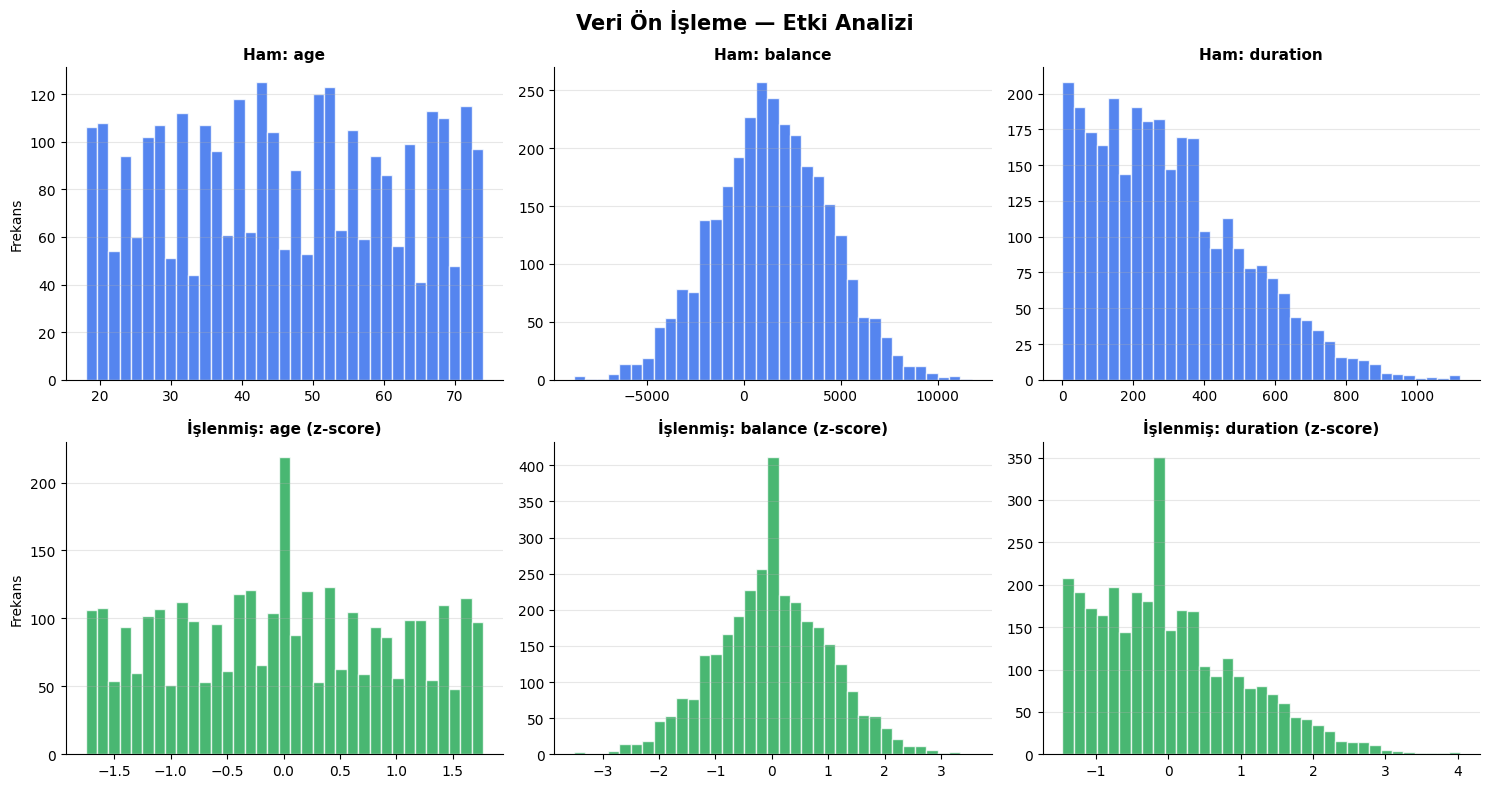

    ✅ Grafik kaydedildi: 01_on_isleme_etki.png


In [22]:
# ═════════════════════════════════════════════════════════════
# 7. GÖRSELLEŞTİRME
# ═════════════════════════════════════════════════════════════
print("\n[7] Görselleştirmeler hazırlanıyor...")

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle("Veri Ön İşleme — Etki Analizi", fontsize=15, fontweight="bold")

cols_plot = [c for c in ["age", "balance", "duration"] if c in num_cols]

for i, col in enumerate(cols_plot):
    cidx = num_cols.index(col)

    # Ham veri (eksik hariç)
#enumerate → Hem indeks (i) hem değeri (col) birlikte verir.
#dropna() → Eksik değerleri atarak histogram çizer (histogram NaN kabul etmez).
#bins=35 → Histogramı 35 çubuğa böler.
#alpha=0.78 → Hafif şeffaflık. 0=tamamen şeffaf, 1=tam opak.
    raw = X_train[col].dropna()
    axes[0, i].hist(raw, bins=35, color="#2563EB", alpha=0.78, edgecolor="white")
    axes[0, i].set_title(f"Ham: {col}", fontweight="bold", fontsize=11)
    axes[0, i].set_ylabel("Frekans" if i == 0 else "")
    axes[0, i].grid(axis="y", alpha=0.3)

    # İşlenmiş veri
    proc = X_train_scaled[:, cidx]
    axes[1, i].hist(proc, bins=35, color="#16A34A", alpha=0.78, edgecolor="white")
    axes[1, i].set_title(f"İşlenmiş: {col} (z-score)", fontweight="bold", fontsize=11)
    axes[1, i].set_ylabel("Frekans" if i == 0 else "")
    axes[1, i].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("01_on_isleme_etki.png", dpi=150, bbox_inches="tight")
plt.show()
print("    ✅ Grafik kaydedildi: 01_on_isleme_etki.png")
plt.close()

In [28]:
print("Ham Veri (Üst Satır)")
print("Age (Yaş)")
print("X ekseni 20–75 arasında. Dağılım oldukça düzgün ve yayvan, belirgin bir tepe noktası yok. Gerçek hayatta beklenen bir şey: müşteriler her yaştan geliyor.")
print("Balance (Bakiye)")
print("X ekseni −5.000 ile +10.000 arasında geniş bir aralıkta. Tepe noktası 0 civarında, sağa doğru uzun bir kuyruk var. Bu, çoğu müşterinin düşük bakiyede olduğunu, az sayıda müşterinin ise çok yüksek bakiyeye sahip olduğunu gösteriyor — tipik bir sağa çarpık dağılım.")
print("Duration (Görüşme Süresi)")
print("X ekseni 0'dan 1.000'in üzerine kadar uzanıyor. Neredeyse tüm değerler 0–400 aralığında yığılmış, sağa doğru çok uzun bir kuyruk var. Bu da sağa çarpık bir dağılım. Yani çoğu görüşme kısa, çok az görüşme çok uzun sürüyor.")

print("İşlenmiş Veri / z-score (Alt Satır)")
print("Age (Yaş)")
print("X ekseni artık −1.5 ile +1.5 arasında. Dağılımın şekli hiç değişmedi, sadece eksen sıkıştı. Bu tam olarak beklenen davranış: StandardScaler şekli değiştirmez, sadece ölçeği değiştirir.")
print("Balance (Bakiye)")
print("X ekseni artık −3 ile +3 arasında. Sağa çarpıklık hâlâ mevcut ama değerlerin tamamı artık makul bir aralıkta. Eskiden −5.000 ile +10.000 arasındaki değerler, şimdi −3 ile +3 arasına sıkıştı.")
print("Duration (Görüşme Süresi)")
print("X ekseni −1 ile +4 arasında. Sağa çarpıklık burada da devam ediyor. Dikkat: sağ kuyruk artık +4'e kadar uzanıyor — bu aykırı değerlerin (çok uzun görüşmeler) z-score'da nasıl öne çıktığını gösteriyor.")
print("StandardScaler dağılımı normalleştirmiyor, sadece ölçeklendiriyor. Farklı birimlerdeki sütunlar artık aynı ölçekte, model adil değerlendirme yapabilir")

Ham Veri (Üst Satır)
Age (Yaş)
X ekseni 20–75 arasında. Dağılım oldukça düzgün ve yayvan, belirgin bir tepe noktası yok. Gerçek hayatta beklenen bir şey: müşteriler her yaştan geliyor.
Balance (Bakiye)
X ekseni −5.000 ile +10.000 arasında geniş bir aralıkta. Tepe noktası 0 civarında, sağa doğru uzun bir kuyruk var. Bu, çoğu müşterinin düşük bakiyede olduğunu, az sayıda müşterinin ise çok yüksek bakiyeye sahip olduğunu gösteriyor — tipik bir sağa çarpık dağılım.
Duration (Görüşme Süresi)
X ekseni 0'dan 1.000'in üzerine kadar uzanıyor. Neredeyse tüm değerler 0–400 aralığında yığılmış, sağa doğru çok uzun bir kuyruk var. Bu da sağa çarpık bir dağılım. Yani çoğu görüşme kısa, çok az görüşme çok uzun sürüyor.
İşlenmiş Veri / z-score (Alt Satır)
Age (Yaş)
X ekseni artık −1.5 ile +1.5 arasında. Dağılımın şekli hiç değişmedi, sadece eksen sıkıştı. Bu tam olarak beklenen davranış: StandardScaler şekli değiştirmez, sadece ölçeği değiştirir.
Balance (Bakiye)
X ekseni artık −3 ile +3 arasında. Sağ

In [21]:
# ═════════════════════════════════════════════════════════════
# 8. FIT vs TRANSFORM — CANLI GÖSTERIM
# ═════════════════════════════════════════════════════════════
print("\n[8] fit() ile transform() farkı — canlı demo")
print("─" * 45)

demo = pd.DataFrame({
    "A": [1.0, 2.0, np.nan, 4.0, 5.0],
    "B": [10.0, np.nan, 30.0, 40.0, 50.0],
})
demo_yeni = pd.DataFrame({"A": [np.nan, 3.0], "B": [20.0, np.nan]})

imp_demo = SimpleImputer(strategy="mean")
imp_demo.fit(demo)

print("  Eğitim verisi:")
print(demo.to_string())
print(f"\n  Öğrenilen ortalamalar: A={imp_demo.statistics_[0]:.1f}, B={imp_demo.statistics_[1]:.1f}")

print("\n  Yeni veri (test):")
print(demo_yeni.to_string())
print("\n  transform() uygulandı (eğitim ortalamalarıyla):")
print(pd.DataFrame(imp_demo.transform(demo_yeni), columns=["A", "B"]).to_string())
print("\n  ↑ Test verisinin kendi ortalaması KULLANILMADI — Doğru!")

print("\n" + "=" * 60)
print("  ✅ UYGULAMA 01 TAMAMLANDI")
print("  Çıktılar: 01_on_isleme_etki.png")
print("=" * 60)


[8] fit() ile transform() farkı — canlı demo
─────────────────────────────────────────────
  Eğitim verisi:
     A     B
0  1.0  10.0
1  2.0   NaN
2  NaN  30.0
3  4.0  40.0
4  5.0  50.0

  Öğrenilen ortalamalar: A=3.0, B=32.5

  Yeni veri (test):
     A     B
0  NaN  20.0
1  3.0   NaN

  transform() uygulandı (eğitim ortalamalarıyla):
     A     B
0  3.0  20.0
1  3.0  32.5

  ↑ Test verisinin kendi ortalaması KULLANILMADI — Doğru!

  ✅ UYGULAMA 01 TAMAMLANDI
  Çıktılar: 01_on_isleme_etki.png
